# Overview

Example of loading text data and metadata in Python and visualizing some interactions between patterns in metadata and text (simple word frequencies).

The text data is organized as text files in directories. The metadata for documents in the corpus is in a CSV file.

# Load data

In [1]:
# Read in metadata, as a dictionary of pandas dataframes

import os
import pandas as pd

# pandas display settings
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 10000)

metadata_dirpath = '/usr2/scratch/fanfic/'

fandoms = [
    'allmarvel',
    'dcu',
    'harrypotter',
    'sherlock',
    'starwars',
    'song_ice_fire',
    'supernatural',
    'teenwolf',
]


metadata = {}
for fandom in fandoms:
    metadata_fpath = os.path.join(metadata_dirpath, f'ao3_{fandom}_text', 'stories.csv')
    metadata[fandom] = pd.read_csv(metadata_fpath)

metadata['allmarvel']

,fic_id,title,author,author_key,rating,category,fandom,relationship,character,additional tags,language,published,status,status date,words,comments,kudos,bookmarks,hits,chapter_count,series,seriespart,seriesid
0,1000010,Bellwether,kaige68,kaige68,"[""General Audiences""]","[""M/M""]","[""The Avengers (Marvel Movies)"", ""Agents of S.H.I.E.L.D. (TV)""]","[""Clint Barton/Phil Coulson""]","[""Clint Barton"", ""Phil Coulson""]","[""Drabble"", ""Community: 1_million_words""]",English,2013-10-05,Completed,NaN,100.0,2.0,27.0,1.0,707.0,1,NaN,NaN,NaN
1,1000013,Estrella Nuclear,Badguy_x_Moores,Badguy_x_Moores,"[""Explicit""]","[""M/M""]","[""The Avengers (Marvel Movies)""]","[""Loki/Tony Stark""]","[""Loki (Marvel)"", ""Tony Stark""]","[""Romance"", ""Sex"", ""Slash""]",Español,2013-10-11,Completed,NaN,5037.0,NaN,6.0,NaN,378.0,1,NaN,NaN,NaN
2,1000017,Don't Let Go,helens78,helens78,"[""Teen And Up Audiences""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier"", ""Kurt Marko""]","[""Community: fan_flashworks"", ""Violence"", ""Alternate Universe - Role Reversal"", ""Role Reversal"", ""First Meetings"", ""Revenge"", ""Childhood Trauma""]",English,2013-09-06,Completed,NaN,1187.0,13.0,229.0,37.0,2497.0,1,NaN,NaN,NaN
3,1000018,You're All I Want (My Fantasy),helens78,helens78,"[""General Audiences""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier""]","[""Community: fan_flashworks"", ""Epic Bromance World Tour"", ""Gay Mutant Road Trip"", ""Photographs"", ""1960s"", ""Gay and Mutant in the 1960s"", ""Podfic Available""]",English,2013-10-11,Completed,NaN,598.0,2.0,107.0,17.0,1388.0,1,NaN,NaN,NaN
4,1000019,No Expectations,helens78,helens78,"[""Explicit""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier""]","[""Community: fan_flashworks"", ""Shower Sex"", ""Masturbation in Shower"", ""First Time"", ""Resolved Sexual Tension""]",English,2013-10-11,Completed,NaN,807.0,5.0,496.0,51.0,6522.0,1,NaN,NaN,NaN
5,1000020,Learning To Call You Home,helens78,helens78,"[""Mature""]","[""M/M""]","[""X-Men: First Class (2011) - Fandom""]","[""Erik Lehnsherr/Charles Xavier""]","[""Erik Lehnsherr"", ""Charles Xavier"", ""Hank McCoy"", ""Logan (X-Men)"", ""Ororo Munroe"", ""Jean Grey"", ""Scott Summers""]","[""Community: fan_flashworks"", ""Reverse Chronology"", ""Starting Over"", ""Canon Disabled Character"", ""Post-Canon"", ""Angst"", ""Implied/Referenced Mind Control"", ""Community: hc_bingo"", ""Hurt/Comfort""]",English,2013-10-11,Completed,NaN,907.0,4.0,121.0,12.0,1882.0,1,NaN,NaN,NaN
6,1000036,Bestow,kaige68,kaige68,"[""General Audiences""]","[""Gen""]","[""The Avengers (Marvel Movies)"", ""Agents of S.H.I.E.L.D. (TV)""]",[],"[""Phil Coulson"", ""Thor (Marvel)""]","[""Dialogue-Only"", ""Drabble"", ""Community: 1_million_words""]",English,2013-10-06,Completed,NaN,100.0,2.0,13.0,NaN,269.0,1,NaN,NaN,NaN
7,1000040,Rencarnación,Badguy_x_Moores,Badguy_x_Moores,"[""Teen And Up Audiences""]","[""M/M""]","[""The Avengers (Marvel Movies)"", ""Sherlock Holmes (Downey films)""]","[""Loki/Tony Stark"", ""Sherlock Holmes/John Watson""]","[""Sherlock Holmes"", ""Tony Stark"", ""Loki (Marvel)"", ""John Watson"", ""Thor (Marvel)"", ""Bruce Banner"", ""Steve Rogers"", ""Gregory Stark""]","[""Romance"", ""Humor"", ""Fluff and Angst""]",Español,2013-10-11,Completed,NaN,4928.0,NaN,17.0,3.0,618.0,1,NaN,NaN,NaN
8,10000463,off-book,zauberer_sirin,zauberer_sirin,"[""General Audiences""]","[""F/M""]","[""Agents of S.H.I.E.L.D. (TV)""]","[""Phil Coulson/Skye | Daisy Johnson""]","[""Skye | Daisy Johnson"", ""Phil Coulson""]","[""Future Fic"", ""First Kiss"", ""POV Skye | Daisy Johnson""]",English,2017-02-28,Completed,NaN,685.0,2.0,12.0,2.0,199.0,1,makeouts are mandatory,5.0,667724.0
9,1000058,Edify,kaige68,kaige68,"[""General Audiences""]

In [3]:
# Sample 1000 stories from each fandom, store in a dictionary of IDs with fandom names as the keys

sampled_fic_ids = {}

for fandom in fandoms:
    sampled_fic_ids[fandom] = metadata[fandom]['fic_id'].sample(1000).tolist()
    
sampled_fic_ids['dcu']

[14035296,
 10430931,
 177830,
 7653385,
 11623362,
 343511,
 10375854,
 9673559,
 11821098,
 4830563,
 14822058,
 4103437,
 11503725,
 11472066,
 12406002,
 6073783,
 67079,
 4962916,
 504968,
 7993795,
 3988414,
 14572428,
 3172776,
 6316198,
 15980360,
 900390,
 16116032,
 13655160,
 353909,
 5784349,
 13549959,
 16395173,
 4212591,
 14831966,
 12055233,
 15915657,
 8525575,
 11716404,
 13707933,
 8596414,
 4239996,
 8844829,
 5441849,
 7094977,
 21483,
 6345211,
 5490653,
 12773976,
 11893866,
 211546,
 4591515,
 448495,
 14333646,
 14738582,
 10951557,
 42989,
 16091294,
 899412,
 15863511,
 13055445,
 15934121,
 5193155,
 14668755,
 323520,
 11492646,
 6939244,
 4432289,
 1276003,
 7268077,
 12138588,
 11414544,
 4987585,
 355764,
 1130311,
 11805477,
 16661515,
 7778347,
 1104133,
 4023544,
 8180893,
 3851572,
 5651011,
 8102854,
 9573083,
 15818457,
 8473573,
 4686341,
 5258777,
 16347536,
 9112291,
 8659795,
 10859151,
 16459532,
 14168862,
 13158657,
 6372613,
 2020914,
 8626

# Preprocess data

In this case our data is already preprocessed, but important steps to think about include:

* Lowercasing
    - Does case matter?
* Tokenization: breaking text into words.
    - Almost always a good idea
    - Breaks up possessives (Henry's -> Henry 's)
* Stopwords
    - Are common function words such as "the", "in" or "I" important?
    
### An example before and after preprocessing

BEFORE: The cat's toy sat completely still on the windowsill.  
AFTER: cat 's toy sat completely still windowsill .

In [17]:
# Load preprocessed story text
from tqdm import tqdm_notebook as tqdm

stories_dirpath = '/usr2/mamille2/fanfiction-project/data/ao3/'
stories = {fandom: {} for fandom in fandoms}

for fandom in tqdm(fandoms):
    for fic_id in sampled_fic_ids[fandom]:
        story_fpath = os.path.join(stories_dirpath, fandom, 'fics_paras', f'{fic_id}.txt')
        
        if not os.path.exists(story_fpath):
            # Try other naming
            story_fpath = os.path.join(stories_dirpath, fandom, 'fics_paras', f'{fic_id}_tokenized_paras.txt')
            
        if not os.path.exists(story_fpath):
            continue
        
        with open(story_fpath) as f:
            stories[fandom][fic_id] = f.read()
            
print(fandom)
print(fic_id)
stories[fandom][fic_id]


teenwolf
4643859


"she should go back , should return the guards ' calls but all reasonable thought had left her . she felt driven , compelled to carry on through the brambles and thorns . this excursion from her caretaker had begun a whimsical adventure but now was something much grander and much more obscure .\nthere was no path to follow   but her mystery led her deeper into the woods , the trees growing taller and thicker as she pushed onward . the glimmer of sun splashed in between the blanket of forest , red following the mysterious object as it floated further away .\nallison . allison .\nshe could n't turn back , not yet . she felt as though she could almost touch the red-- touch the glimmering sunlight that traveled through the woods like magic . she was so close but she could hardly explain what made her desire the glimmering light so ... could hardly say what it was that pressed her forward . but she could n't stop .\nallison .\nshe dropped her skirts as she stumbled against a tree only to hi

# Visualize some trends

## Basic statistics across fandoms

In [7]:
# Average fic length across fandom

avg_fic_lengths = {}

for fandom in fandoms:
    avg_fic_lengths[fandom] = metadata[fandom]['words'].mean()
    
avg_fic_lengths

{'allmarvel': 6340.572692113122,
 'dcu': 6436.082340756085,
 'harrypotter': 8926.514089454375,
 'sherlock': 5840.655792911082,
 'starwars': 7516.378565865057,
 'song_ice_fire': 9863.427027781656,
 'supernatural': 6234.203054811565,
 'teenwolf': 6474.4850016783475}

In [9]:
import operator

sorted_fic_lengths = sorted(avg_fic_lengths.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_fic_lengths))
print(labels)
print(values)

('sherlock', 'supernatural', 'allmarvel', 'dcu', 'teenwolf', 'starwars', 'harrypotter', 'song_ice_fire')
(5840.655792911082, 6234.203054811565, 6340.572692113122, 6436.082340756085, 6474.4850016783475, 7516.378565865057, 8926.514089454375, 9863.427027781656)


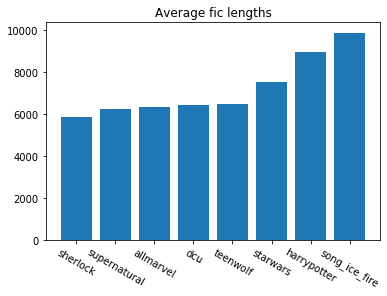

In [11]:
import matplotlib.pyplot as plt

plt.title("Average fic lengths")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

In [ ]:
# Fandom story age

## Perhaps more interesting...

In [13]:
# Distribution of ships, relationship types across fandoms

proportion_mm = {}

# Proportion of stories with M/M
for fandom in fandoms:
    fics_with_mm = sum(metadata[fandom]['category'].map(lambda x: 'M/M' in x))
    proportion_mm[fandom] = fics_with_mm/len(metadata[fandom])
    
proportion_mm

{'allmarvel': 0.47835236541598697,
 'dcu': 0.3677397432059611,
 'harrypotter': 0.47198827247543296,
 'sherlock': 0.6023044217687075,
 'starwars': 0.382001970587162,
 'song_ice_fire': 0.145094645150483,
 'supernatural': 0.6187985977490181,
 'teenwolf': 0.725180280515465}

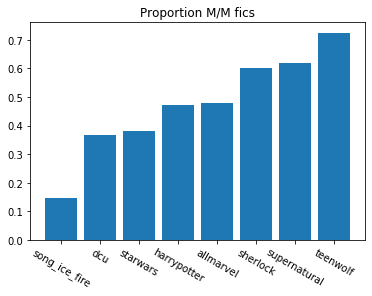

In [15]:
import operator

sorted_proportions = sorted(proportion_mm.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_proportions))

plt.title("Proportion M/M fics")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

In [25]:
# Do fandoms with LGBTQ ships use more LGBTQ labels?
lgbtq_labels = ['transgender', 'trans', 'queer', 'lesbian', 'gay', 'homosexual']
cishet_labels = ['heterosexual', 'cisgender', 'cis']

# Count terms
word_totals = {}
lgbtq_term_counts = {fandom: {} for fandom in fandoms} # fandom: term

for fandom in tqdm(fandoms):
    word_totals[fandom] = 0
    for term in lgbtq_labels:
        lgbtq_term_counts[fandom][term] = 0
        for fic_id in sampled_fic_ids[fandom]:
            lgbtq_term_counts[fandom][term] += stories[fandom][fic_id].replace('\n', ' ').count(term)
            word_totals[fandom] += len(stories[fandom][fic_id].split())
            
print(lgbtq_term_counts)
print(word_totals)


{'allmarvel': {'transgender': 1, 'trans': 750, 'queer': 51, 'lesbian': 21, 'gay': 286, 'homosexual': 23}, 'dcu': {'transgender': 6, 'trans': 711, 'queer': 16, 'lesbian': 50, 'gay': 204, 'homosexual': 5}, 'harrypotter': {'transgender': 1, 'trans': 1996, 'queer': 36, 'lesbian': 33, 'gay': 298, 'homosexual': 26}, 'sherlock': {'transgender': 3, 'trans': 650, 'queer': 20, 'lesbian': 27, 'gay': 316, 'homosexual': 20}, 'starwars': {'transgender': 1, 'trans': 1465, 'queer': 7, 'lesbian': 3, 'gay': 95, 'homosexual': 2}, 'song_ice_fire': {'transgender': 0, 'trans': 470, 'queer': 86, 'lesbian': 8, 'gay': 93, 'homosexual': 2}, 'supernatural': {'transgender': 0, 'trans': 559, 'queer': 24, 'lesbian': 18, 'gay': 276, 'homosexual': 21}, 'teenwolf': {'transgender': 0, 'trans': 647, 'queer': 8, 'lesbian': 11, 'gay': 280, 'homosexual': 8}}
{'allmarvel': 50768682, 'dcu': 48497928, 'harrypotter': 67528926, 'sherlock': 43461528, 'starwars': 51151710, 'song_ice_fire': 59617290, 'supernatural': 43462836, 'te

In [23]:
lgbtq_term_totals = {fandom: sum(lgbtq_term_counts[fandom].values()) for fandom in fandoms}
lgbtq_term_totals

{'allmarvel': 1132,
 'dcu': 992,
 'harrypotter': 2390,
 'sherlock': 1036,
 'starwars': 1573,
 'song_ice_fire': 659,
 'supernatural': 898,
 'teenwolf': 954}

In [26]:
lgbtq_term_proportions = {fandom: lgbtq_term_totals[fandom]/word_totals[fandom] for fandom in fandoms}
lgbtq_term_proportions

{'allmarvel': 2.2297210709547277e-05,
 'dcu': 2.04544820966372e-05,
 'harrypotter': 3.5392240652546436e-05,
 'sherlock': 2.3837173879390526e-05,
 'starwars': 3.0751660110678607e-05,
 'song_ice_fire': 1.105384025338958e-05,
 'supernatural': 2.066133006138854e-05,
 'teenwolf': 2.1125188665206947e-05}

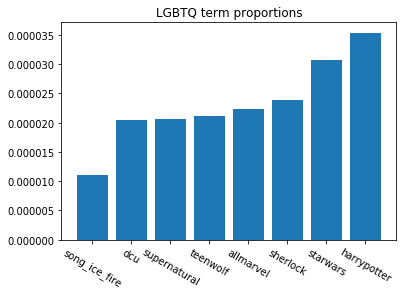

In [29]:
# Todo: Make a scatter plot, put in log space

sorted_term_proportions = sorted(lgbtq_term_proportions.items(), key=operator.itemgetter(1))
labels, values = list(zip(*sorted_term_proportions))

plt.title("LGBTQ term proportions")
plt.bar(labels, values)
plt.xticks(rotation=-30)
plt.show()

# Find this tutorial

